In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from xgboost import XGBClassifier as XGB
import lightgbm as lgb

# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [21]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [23]:
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [25]:
# One-Hot encoding our categorical attributes
list_cat = ['Geography', 'Gender']
data = pd.get_dummies(data, columns = list_cat, prefix = list_cat, dtype=int)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [27]:
data = data.drop(['CustomerId', 'Surname','RowNumber'], axis = 1)

In [37]:
# Feature engineering
data['Balance_to_Salary_Ratio'] = data['Balance'] / (data['EstimatedSalary'] + 1)
data['Age_to_Tenure_Ratio'] = data['Age'] / (data['Tenure'] + 1)
data['TotalValue'] = data['Balance'] + data['EstimatedSalary']
data['ProductsPerTenure'] = data['NumOfProducts'] / (data['Tenure'] + 1)
data['CreditScoreGroup'] = pd.qcut(data['CreditScore'], q=10, labels=False)
data['BalanceGroup'] = pd.qcut(data['Balance'].rank(method='first'), q=10, labels=False)
data['IsHighRisk'] = ((data['CreditScore'] < 600) & (data['Balance'] > data['Balance'].mean())).astype(int)
data['CustomerValue'] = data['Balance'] * 0.4 + data['EstimatedSalary'] * 0.3 + data['Tenure'] * 0.2
data['IsRetirementAge'] = (data['Age'] > 60).astype(int)
data['BalancePerAge'] = data['Balance'] / (data['Age'] + 1)
data


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,...,Balance_to_Salary_Ratio,Age_to_Tenure_Ratio,TotalValue,ProductsPerTenure,CreditScoreGroup,BalanceGroup,IsHighRisk,CustomerValue,IsRetirementAge,BalancePerAge
0,619,42,2,119808.30,1,1,1,101348.88,1,1,...,1.182126,14.000000,221157.18,0.333333,3,3,0,78328.384,0,2786.239535
1,608,41,1,83807.86,1,0,1,112542.58,0,0,...,0.744670,20.500000,196350.44,0.500000,3,0,0,67286.118,0,1995.425238
2,502,42,8,159660.80,3,1,0,113931.57,1,1,...,1.401362,4.666667,273592.37,0.333333,0,9,1,98045.391,0,3713.041860
3,699,39,1,119808.30,2,0,0,93826.63,0,1,...,1.276898,19.500000,213634.93,1.000000,6,3,0,76071.509,0,2995.207500
4,850,43,2,125510.82,1,1,1,79084.10,0,0,...,1.587035,14.333333,204594.92,0.333333,9,7,0,73929.958,0,2852.518636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9621,771,39,5,119808.30,2,1,0,96270.64,0,1,...,1.244482,6.500000,216078.94,0.333333,8,6,0,76805.512,0,2995.207500
9622,516,35,10,57369.61,1,1,1,101699.77,0,1,...,0.564102,3.181818,159069.38,0.090909,0,0,0,53459.775,0,1593.600278
9623,709,36,7,119808.30,1,0,1,42085.58,1,1,...,2.846710,4.500000,161893.88,0.125000,7,6,0,60550.394,0,3238.062162
9624,772,42,3,75075.31,2,1,0,92888.52,1,0,...,0.808222,10.500000,167963.83,0.500000,8,0,0,57897.280,0,1745.937442


In [29]:
data.dtypes

CreditScore            int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_France       int32
Geography_Germany      int32
Geography_Spain        int32
Gender_Female          int32
Gender_Male            int32
dtype: object

In [31]:
features = list(data.drop('Exited', axis = 1))
target = 'Exited'

In [33]:

train, test = train_test_split(data, test_size = 0.2, random_state = 1)

print('Number of clients in the dataset: {}'.format(len(data)))
print('Number of clients in the train set: {}'.format(len(train)))
print('Number of clients in the test set: {}'.format(len(test)))

Number of clients in the dataset: 10000
Number of clients in the train set: 8000
Number of clients in the test set: 2000


In [35]:
sc = StandardScaler()

# fit on training set
train[features] = sc.fit_transform(train[features])

# only transform on test set
test[features] = sc.transform(test[features])

In [37]:
def resample_data(data, target):
    data_1 = data[data[target] == 1]
    data_0 = data[data[target] == 0]
    percentage = len(data_1)/len(data_0)
    temp = data_0.sample(frac = percentage, random_state = 1)

    data_new = data_1.append(temp)
    data_new.sort_index(inplace = True)
    return data_new

In [39]:
def resample_data(data, target):
    majority = data[data[target] == 0]
    minority = data[data[target] == 1]
    minority_upsampled = minority.sample(len(majority), replace=True)
    return pd.concat([majority, minority_upsampled])  # ✅ Updated


In [41]:
trainB = resample_data(train, target = target)
print('Number of clients in the dataset is : {}'.format(len(data)))
print('Number of clients in the balanced train set is : {}'.format(len(trainB)))
print('Number of clients in the test set is : {}'.format(len(test)))

Number of clients in the dataset is : 10000
Number of clients in the balanced train set is : 12756
Number of clients in the test set is : 2000


In [43]:
exited_trainB = len(trainB[trainB['Exited'] == 1]['Exited'])
exited_trainB_perc = round(exited_trainB/len(trainB)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Balanced Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_trainB, exited_trainB_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

Balanced Train set - Number of clients that have exited the program: 6378 (50.0%)
Test set - Number of clients that haven't exited the program: 415 (20.8%)


2.5.1 Logistic Regresstion

In [46]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.130117,0.020849,0.010046,0.001685,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.708464,0.712270,0.696198,0.682477,0.695022,0.698886,0.010604,49
1,0.084869,0.015125,0.009783,0.004473,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.708464,0.712270,0.696198,0.682477,0.694238,0.698729,0.010666,58
2,0.048565,0.014038,0.005382,0.001976,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.713950,0.711094,0.695414,0.685221,0.692670,0.699670,0.011048,46
3,0.186324,0.008823,0.011445,0.004545,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.708464,0.712270,0.696198,0.682477,0.695022,0.698886,0.010604,49
4,0.212973,0.043916,0.009111,0.001575,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.708464,0.712270,0.696198,0.682477,0.695022,0.698886,0.010604,49
5,0.086076,0.007181,0.010721,0.002537,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.708464,0.712270,0.696198,0.682477,0.695022,0.698886,0.010604,49
6,0.036245,0.012188,0.008903,0.003821,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.708464,0.712270,0.696198,0.682477,0.694238,0.698729,0.010666,58
7,0.050280,0.004518,0.007023,0.001408,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.713950,0.711094,0.695414,0.685221,0.692670,0.699670,0.011048,46
8,0.168714,0.034328,0.009778,0.005403,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.708464,0.712270,0.696198,0.682477,0.695022,0.698886,0.010604,49
9,0.208471,0.039177,0.007262,0.004887,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.708464,0.712270,0.696198,0.682477,0.695022,0.698886,0.010604,49


In [47]:
print(model_LR.best_params_)

{'C': 0.1, 'max_iter': 100, 'solver': 'saga'}


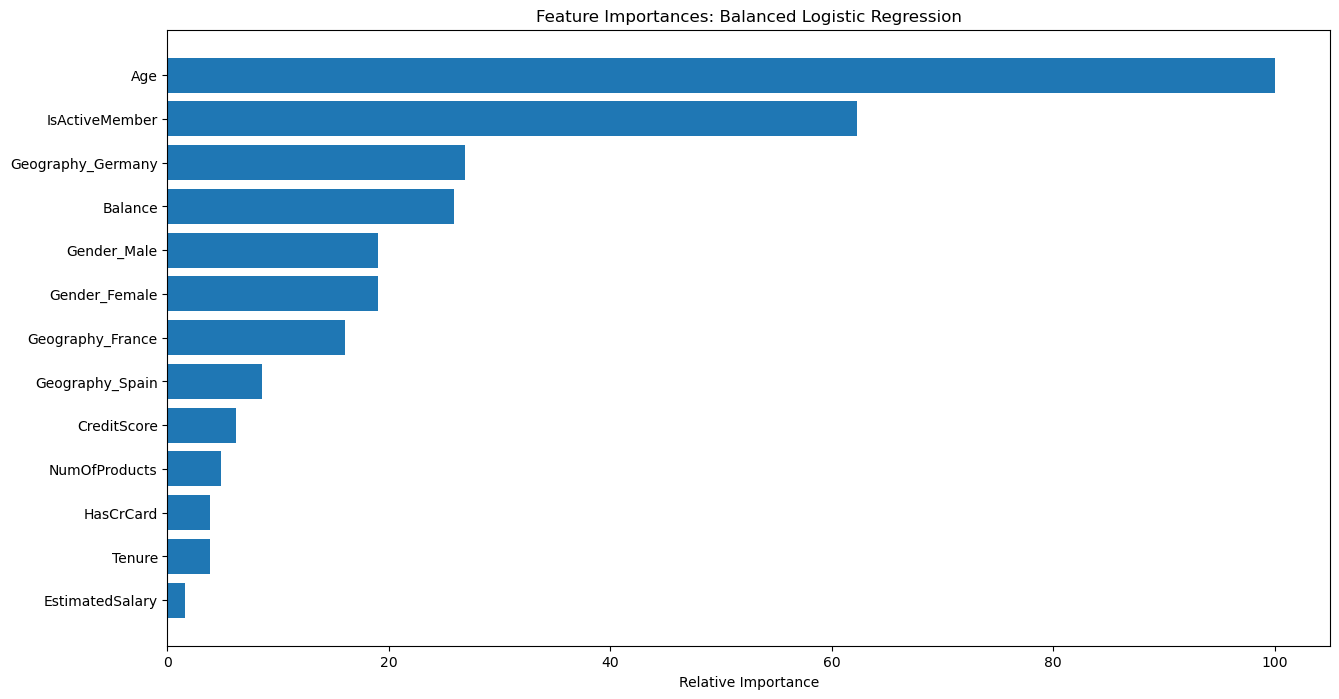

In [50]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(trainB[features], trainB[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

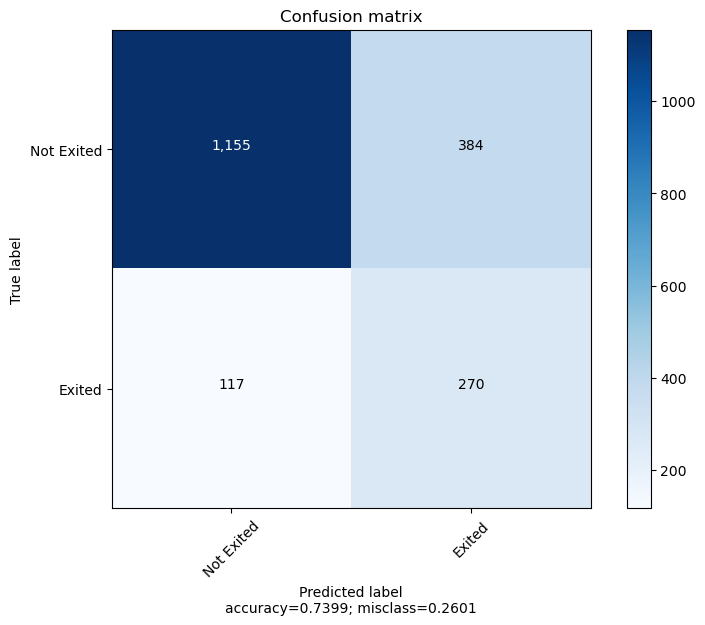

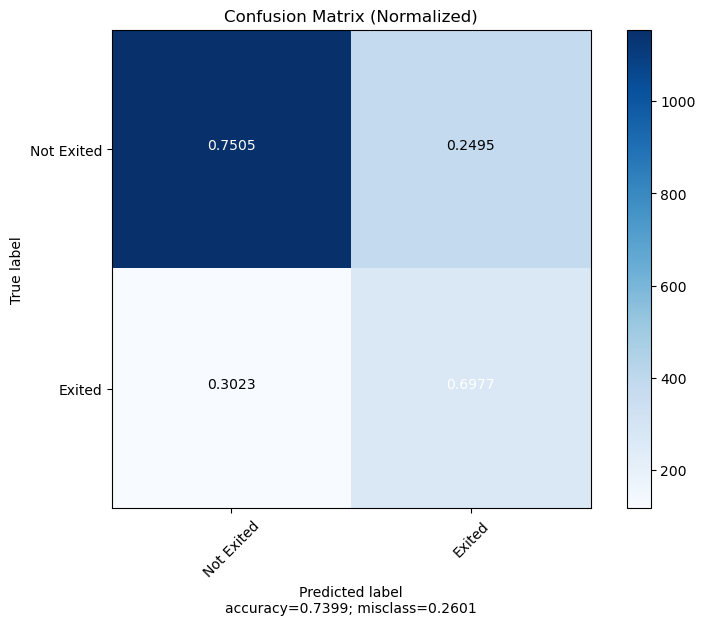

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.739875,0.724081,0.78485,0.908019,0.750487,0.821772,0.412844,0.697674,0.518732


In [61]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

table_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
table_of_models

2.5.3 Gradient Boosting Classifier (Sklearn)

In [52]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.877172,0.309589,0.024484,0.011352,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.778605,0.782438,0.761662,0.771462,0.778910,0.774616,0.007393,24
1,4.112263,0.542734,0.022985,0.004858,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.780956,0.787534,0.766758,0.777342,0.788318,0.780182,0.007863,23
2,13.733451,2.501330,0.046392,0.008130,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.805643,0.797334,0.785574,0.787142,0.809094,0.796958,0.009474,19
3,22.749626,4.154096,0.065811,0.012852,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.815047,0.813407,0.796942,0.795374,0.817719,0.807698,0.009535,18
4,2.503033,0.019954,0.016502,0.001865,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.788009,0.785966,0.773422,0.774206,0.785966,0.781514,0.006336,22
5,6.563906,1.307396,0.027651,0.004999,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.802508,0.793022,0.779302,0.780870,0.801646,0.791470,0.009881,20
6,16.904619,2.478502,0.046954,0.005079,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.838166,0.833791,0.815759,0.814191,0.831831,0.826747,0.009841,16
7,35.375818,4.829199,0.091393,0.011908,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.852665,0.855743,0.834183,0.831831,0.849079,0.844700,0.009806,14
8,3.876217,0.360598,0.023816,0.004167,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.797022,0.788710,0.776950,0.785182,0.798510,0.789275,0.007928,21
9,8.170714,1.952155,0.033571,0.009304,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.814263,0.809878,0.794590,0.807134,0.815367,0.808247,0.007447,17


In [54]:
print(model_GB.best_params_)

{'max_depth': 15, 'n_estimators': 500}


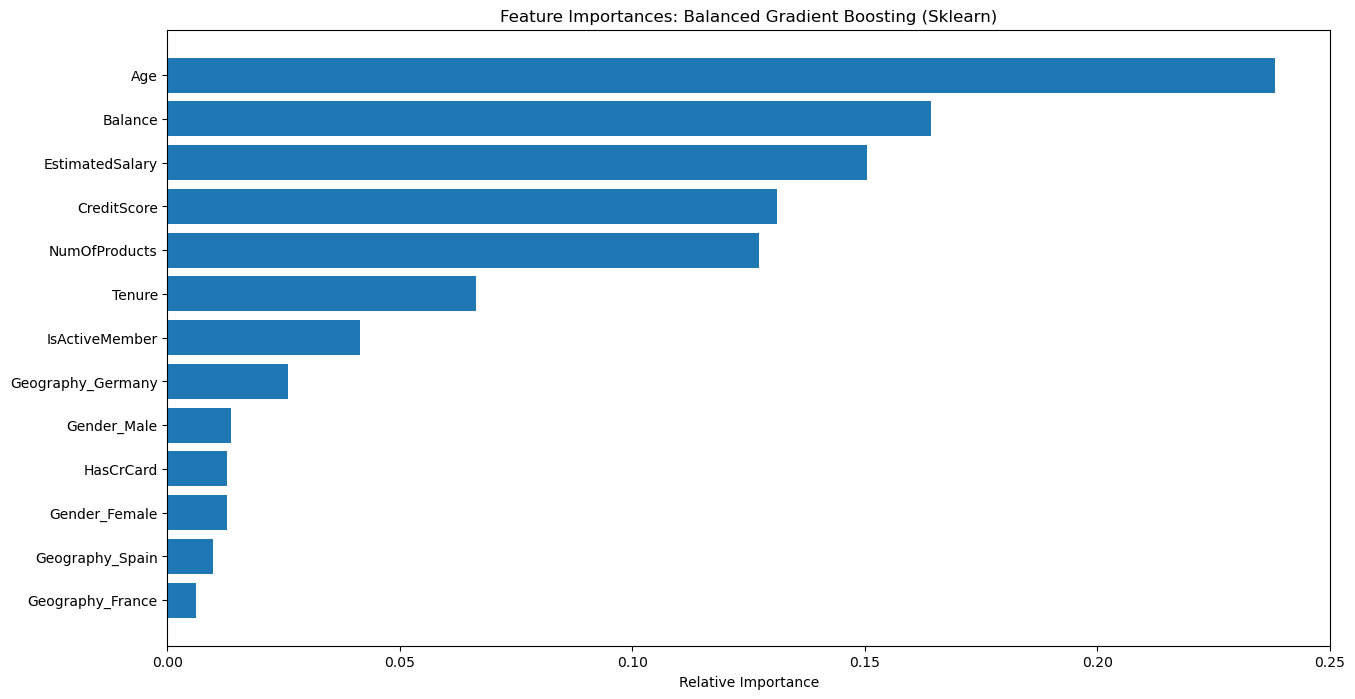

In [56]:
model = GBSklearn(**model_GB.best_params_)
model.fit(trainB[features], trainB[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

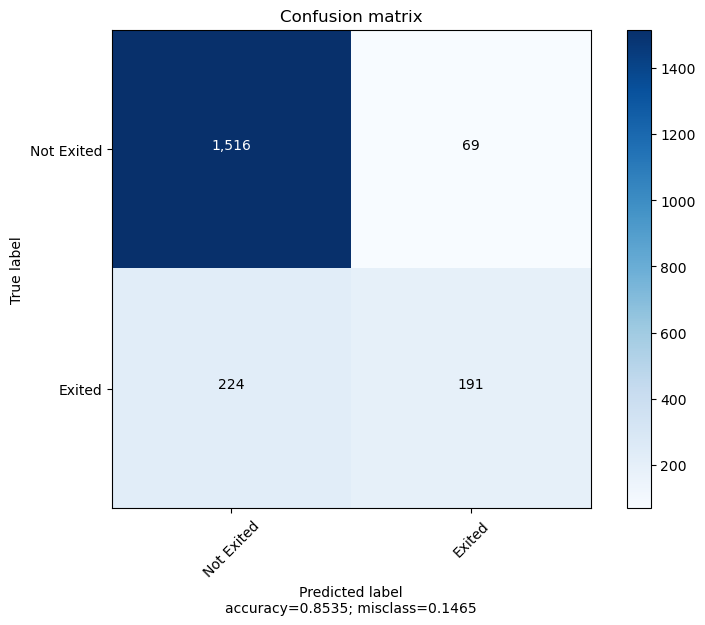

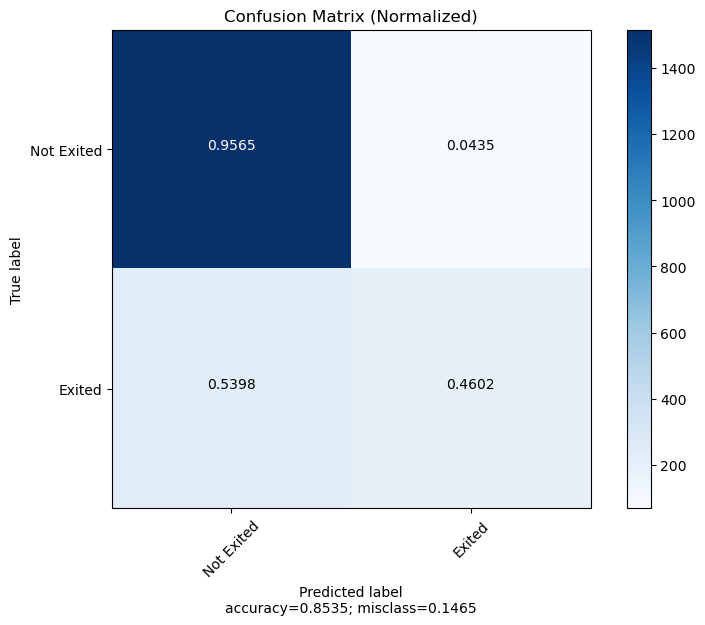

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),yes,0.8535,0.708354,0.852104,0.871264,0.956467,0.91188,0.734615,0.460241,0.565926


In [58]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)', balanced = 'yes')
temp